In [8]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0,1,2,3'

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    EnsureTyped,
    ToTensord,
    Lambdad
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import matplotlib.pyplot as plt
# %matplotlib inline
from PIL import Image
from tqdm import tqdm 
import functools

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import natsort
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai import data, transforms
from monai.utils import first, set_determinism
from monai.data import NumpyReader
from scipy import ndimage
import numpy as np
from torch.autograd import Variable
import gc
import GPUtil
from monai.inferers import sliding_window_inference
import pydicom
import re
import torchsummary
from torchsummary import summary
import time
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
import glob

gc.collect()
torch.cuda.empty_cache()
GPUtil.showUtilization()

device = torch.device('cuda')

print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

| ID | GPU | MEM |
------------------
|  0 |  0% | 39% |
|  1 |  0% | 35% |
|  2 |  0% | 35% |
|  3 |  0% | 35% |
Count of using GPUs: 4
Current cuda device: 0


In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out
    
    
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=2, output_nc=1, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        encoder_model = [nn.ReflectionPad2d(3),
                         nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                         norm_layer(ngf),
                         nn.ReLU(True)]

        n_downsampling = 3
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            encoder_model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                              norm_layer(ngf * mult * 2),
                              nn.ReLU(True)]

        self.encoder_model = nn.Sequential(*encoder_model)

        self.map_decoder = self.map_build_decoder(ngf, output_nc, norm_layer, use_bias, n_downsampling, n_blocks)
        self.emph_decoder = self.build_decoder(ngf, 2, norm_layer, use_bias, n_downsampling, n_blocks)

    def map_build_decoder(self, ngf, output_nc, norm_layer, use_bias, n_downsampling, n_blocks):
        decoder_model = []
        
        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            decoder_model += [ResnetBlock(ngf*mult, padding_type='reflect', norm_layer=norm_layer, use_dropout=False, use_bias=use_bias)]
        
        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            decoder_model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                                 kernel_size=3, stride=2,
                                                 padding=1, output_padding=1,
                                                 bias=use_bias),
                              norm_layer(int(ngf * mult / 2)),
                              nn.ReLU(True)]
            
        decoder_model += [nn.ReflectionPad2d(3)]
        decoder_model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        decoder_model += [nn.Tanh()]

        return nn.Sequential(*decoder_model)
    
    def build_decoder(self, ngf, output_nc, norm_layer, use_bias, n_downsampling, n_blocks):
        decoder_model = []
        
        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            decoder_model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                                 kernel_size=3, stride=2,
                                                 padding=1, output_padding=1,
                                                 bias=use_bias),
                              norm_layer(int(ngf * mult / 2)),
                              nn.ReLU(True)]
            
        decoder_model += [nn.ReflectionPad2d(3)]
        decoder_model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        decoder_model += [nn.Tanh()]

        return nn.Sequential(*decoder_model)
    
    def forward(self, input):
        encoded = self.encoder_model(input)
        return self.map_decoder(encoded), self.emph_decoder(encoded)

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, img_A, img_B):
        """Standard forward."""
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)
    
generator = ResnetGenerator().apply(weights_init_normal)
discriminator = NLayerDiscriminator().apply(weights_init_normal)

discriminator = nn.DataParallel(discriminator, device_ids=[0,1,2,3])
discriminator.to(device)

model = nn.DataParallel(generator, device_ids=[0,1,2,3])
model.to(device)

DataParallel(
  (module): ResnetGenerator(
    (encoder_model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
    )
    (map_decoder): Sequential(
      (0): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, mom

working...
42600
4800


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


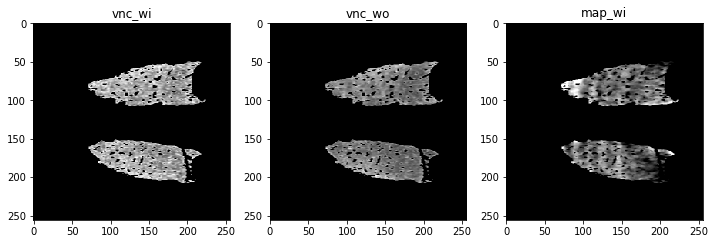

In [3]:
def list_sort_nicely(l):
    def tryint(s):
        try:
            return int(s)
        except:
            return s
    
    def alphanum_key(s):
        return [ tryint(c) for c in re.split('([0-9]+)', s)]
    l.sort(key=alphanum_key)
    return l

print("working...")

map_wi_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/train/map/*/*.dcm"
vnc_wi_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/train/vnc_wi/*/*.dcm"
vnc_wo_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/train/vnc_wo/*/*.dcm"
emph_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/train/emp/*/*.dcm"

map_wis = list_sort_nicely((glob.glob(map_wi_dir)))
vnc_wis = list_sort_nicely((glob.glob(vnc_wi_dir)))
vnc_wos = list_sort_nicely((glob.glob(vnc_wo_dir)))
emphs = list_sort_nicely((glob.glob(emph_dir)))
data_dicts = [{"map_wi": map_wi_name, "vnc_wi": vnc_wi_name, "vnc_wo": vnc_wo_name, "emph": emph_name} for map_wi_name, vnc_wi_name, vnc_wo_name, emph_name in zip(map_wis, vnc_wis, vnc_wos, emphs)]
train_files = data_dicts

map_wi_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/valid/map/*/*.dcm"
vnc_wi_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/valid/vnc_wi/*/*.dcm"
vnc_wo_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/valid/vnc_wo/*/*.dcm"
emph_dir = "/mnt/nas203/forGPU/leesangy/final_dataset/valid/emp/*/*.dcm"

map_wis = list_sort_nicely((glob.glob(map_wi_dir)))
vnc_wis = list_sort_nicely((glob.glob(vnc_wi_dir)))
vnc_wos = list_sort_nicely((glob.glob(vnc_wo_dir)))
emphs = list_sort_nicely((glob.glob(emph_dir)))
data_dicts = [{"map_wi": map_wi_name, "vnc_wi": vnc_wi_name, "vnc_wo": vnc_wo_name, "emph": emph_name} for map_wi_name, vnc_wi_name, vnc_wo_name, emph_name in zip(map_wis, vnc_wis, vnc_wos, emphs)]
val_files = data_dicts

print(len(train_files))
print(len(val_files))

def squeeze(image):
    image = image.squeeze()
    return image

data_transforms = Compose(
    [
        LoadImaged(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        Lambdad(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"], func=squeeze),
        EnsureChannelFirstd(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        ScaleIntensityRanged(keys=["vnc_wi", "vnc_wo"], a_min=-1024.0, a_max=-100.0, b_min=0.0, b_max=1.0, clip=True),
        ScaleIntensityRanged(keys=["map_wi"], a_min=0.0, a_max=50.0, b_min=0.0, b_max=1.0, clip=True),
        #AddChanneld(keys=["image"]),
        #Resized(keys=['image'], spatial_size=[1,224,224]),
        Resized(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"], spatial_size=[256,256]),
        EnsureTyped(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        ToTensord(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"])]
)

check_ds = Dataset(data=val_files, transform=data_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
vnc_wi, vnc_wo, map_wi= (check_data["vnc_wi"][0][0], check_data["vnc_wo"][0][0], check_data["map_wi"][0][0])
print(f"image shape: {vnc_wi.shape}, label shape: {vnc_wo.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 3, 1)
plt.title("vnc_wi")
plt.imshow(vnc_wi[:, :], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("vnc_wo")
plt.imshow(vnc_wo[:, :] , cmap="gray")
plt.subplot(1, 3, 3)
plt.title("map_wi")
plt.imshow(map_wi[:, :] , cmap="gray")

plt.show()

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


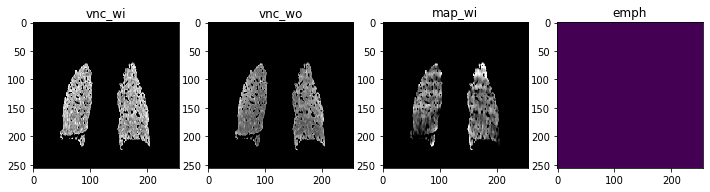

In [4]:
def squeeze(image):
    image = image.squeeze()
    return image

data_transforms = Compose(
    [
        LoadImaged(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        Lambdad(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"], func=squeeze),
        EnsureChannelFirstd(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        ScaleIntensityRanged(keys=["vnc_wi", "vnc_wo"], a_min=-1024.0, a_max=-100.0, b_min=0.0, b_max=1.0, clip=True),
        #ScaleIntensityd(keys=["diff"], minv=0, maxv=1),
        #ScaleIntensityRanged(keys=["diff"], a_min=-1000.0, a_max=-1400.0, b_min=0, b_max=1, clip=True),
        ScaleIntensityRanged(keys=["map_wi"], a_min=0.0, a_max=50.0, b_min=0.0, b_max=1.0, clip=True),
        #AddChanneld(keys=["image"]),
        #Resized(keys=['image'], spatial_size=[1,224,224]),
        Resized(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"], spatial_size=[256,256]),
        EnsureTyped(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"]),
        ToTensord(keys=["map_wi", "vnc_wi", "vnc_wo", "emph"])]
)

check_ds = Dataset(data=val_files, transform=data_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
vnc_wi, vnc_wo, map_wi, emph = (check_data["vnc_wi"][0][0], check_data["vnc_wo"][0][0], check_data["map_wi"][0][0], check_data["emph"][0][0])
print(f"image shape: {vnc_wi.shape}, label shape: {emph.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("vnc_wi")
plt.imshow(np.rot90(vnc_wi[:, :],k=3), cmap="gray")
plt.subplot(1, 4, 2)

plt.title("vnc_wo")
plt.imshow(np.rot90(vnc_wo[:, :],k=3) , cmap="gray")
plt.subplot(1, 4, 3)
plt.title("map_wi")
plt.imshow(np.rot90(map_wi[:, :],k=3) , cmap="gray")
plt.subplot(1, 4, 4)
plt.title("emph")
plt.imshow(np.rot90(emph[:, :],k=3))

plt.show()

In [ ]:
train_ds = CacheDataset(data=train_files, transform=data_transforms, cache_rate=2.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=data_transforms, cache_rate=2.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, shuffle=False)

In [ ]:
# ----------
#  Training
# ----------
class LambdaLR:
    def __init__(self, n_epochs, decay_start_epoch):
        self.n_epochs = n_epochs 
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

b1 = 0.5                
b2 = 0.999  
lr = 0.0002
lambda_pixel = 100
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
optimizer_emph = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
optimizer_G = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1,b2))
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()
seg_loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric_emphy = DiceMetric(include_background=False, reduction="mean")

n_epochs = 600 
decay_epoch = 200 
lr = 0.0002 

lr_scheduler_emph = torch.optim.lr_scheduler.LambdaLR(optimizer_emph, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)

emphy_metric = 0

val_interval = 2
train_check_interval = 2
save_interval = 2

emphy_post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
emphy_post_label = Compose([AsDiscrete(to_onehot=2)])

epoch_emphy_loss = []
epoch_D_map_loss = []
epoch_G_map_loss = []
emphy_metric_values = []
epoch_val_loss = []

best_emphy_metric = -1
best_emphy_metric_epoch = -1

start_time = time.time()

print("training started...")

for epoch in range(1, n_epochs+1):
    step =0
    emphy_loss = 0
    G_map_loss = 0
    D_map_loss =0
    for i, batch in enumerate(train_loader):
        step+=1
        # Model inputs
        real_vnc_wi = batch["vnc_wi"].to(device)
        real_vnc_wo = batch["vnc_wo"].to(device)
        real_emphy_mask = batch["emph"].to(device)
        real_map_wi = batch["map_wi"].to(device)
        
        real_A_cat = torch.cat((real_vnc_wi, real_vnc_wo),1)
        
        # Adversarial ground truths
        valid = Variable(torch.ones(vnc_wi.size()).to(device), requires_grad=False)
        fake = Variable(torch.zeros(vnc_wi.size()).to(device), requires_grad=False)
        
        # ------------------
        # Train Emphysema Segmentation
        # ------------------
        
        optimizer_emph.zero_grad()
        
        map_fake, emphy_mask = model(real_A_cat)
        loss_emph = seg_loss_function(emphy_mask, real_emphy_mask)
        loss_emph.backward()
        
        optimizer_emph.step()
        
        # ------------------
        #  Train MAP Generators
        # ------------------
        
        # GAN loss
        optimizer_G.zero_grad()
        
        map_fake, emphy_mask = model(real_A_cat)
        pred_fake = discriminator(real_A_cat, map_fake)
        
        loss_GAN = criterion_GAN(pred_fake, Variable(torch.ones(pred_fake.size()).to(device), requires_grad=False))
        
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(map_fake, real_map_wi)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A_cat, real_map_wi)
        loss_real = criterion_GAN(pred_real, Variable(torch.ones(pred_real.size()).to(device), requires_grad=False))

        # Fake loss
        pred_fake = discriminator(real_A_cat, map_fake.detach())
        loss_fake = criterion_GAN(pred_fake, Variable(torch.zeros(pred_fake.size()).to(device), requires_grad=False))
        
        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optimizer_D.step()
        
        """ loss values """
        emphy_loss += loss_emph.item()
        G_map_loss += loss_G.item()
        D_map_loss += loss_D.item()
        
        if i % 50 ==0:
            print("\n")
            print("Epoch",f"{epoch}", "#",f"{i}/{len(train_loader)}","iteration", "Elapsed time:", f"{(time.time() - start_time)/60:.2f}", "min")
            print("Emphysema SEG loss:", loss_emph, "MAP Generator loss:", loss_G, "MAP Discriminator loss:", loss_D)
    
    emphy_loss /= step
    G_map_loss /= step
    D_map_loss /= step
    
    epoch_emphy_loss.append(emphy_loss)
    epoch_D_map_loss.append(D_map_loss)
    epoch_G_map_loss.append(G_map_loss)
    
    lr_scheduler_emph.step()
    lr_scheduler_D.step()    
    lr_scheduler_G.step()  
    
    if epoch % val_interval == 0:
        model.eval()
        val_loss_epoch = []
        num =0
        for j, batch in enumerate(val_loader):
            num+=1
            real_vnc_wi = batch["vnc_wi"].to(device)
            real_vnc_wo = batch["vnc_wo"].to(device)
            real_emphy_mask = batch["emph"].to(device)
            real_map_wi = batch["map_wi"].to(device)
            
            real_A_cat = torch.cat((real_vnc_wi, real_vnc_wo),1)
            map_fake, emphy_mask = model(real_A_cat)
            
            
            val_loss = lambda_pixel * criterion_pixelwise(real_map_wi, map_fake)
            val_loss_epoch.append(val_loss.detach().cpu())
            if j % 500 == 0:
                plt.figure("real", (12, 6))
                plt.subplot(1, 4, 1)
                plt.title("vnc_wi")
                plt.imshow(np.rot90(real_vnc_wi.detach().cpu().squeeze(),k=3), cmap="gray")
                plt.subplot(1, 4, 2)
                plt.title("vnc_wo")
                plt.imshow(np.rot90(real_vnc_wo.detach().cpu().squeeze(),k=3), cmap="gray")
                plt.subplot(1, 4, 3)
                plt.title("map_wi")
                plt.imshow(np.rot90(real_map_wi.detach().cpu().squeeze(),k=3), cmap="gray")
                plt.subplot(1, 4, 4)
                plt.title("emph")
                plt.imshow(np.rot90(real_emphy_mask.cpu().squeeze(),k=3))
                plt.savefig(f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/val{j}_real_epoch{epoch}.png", bbox_inches = 'tight')

                plt.figure("outputs", (12, 6))
                plt.subplot(1, 2, 1)
                plt.title("fake_map")
                plt.imshow(np.rot90(map_fake.detach().cpu().squeeze(),k=3), cmap="gray")

                plt.subplot(1, 2, 2)
                plt.title("emphy_SEG")
                plt.imshow(np.rot90(torch.argmax(emphy_mask[0,:,:].squeeze(), dim=0).detach().cpu(),k=3))
                plt.savefig(f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/val{j}_output_epoch{epoch}.png", bbox_inches = 'tight')
            
                print(f"[Val: {j}/{len(val_loader)}] [Elapsed time: {(time.time() - start_time)/60:.2f}min]")
            
            emphy_mask_ = [emphy_post_pred(i) for i in decollate_batch(emphy_mask)]
            real_emphy_mask_ = [emphy_post_label(i) for i in decollate_batch(real_emphy_mask)]
            dice_metric_emphy(y_pred=emphy_mask_, y=real_emphy_mask_)
            
        
        # aggregate the final mean dice result
        emphy_metric = dice_metric_emphy.aggregate().item()
        # reset the status for next validation round
        dice_metric_emphy.reset()
        
        emphy_metric_values.append(emphy_metric)
        
        if emphy_metric > best_emphy_metric:
            best_emphy_metric = emphy_metric
            best_emphy_metric_epoch = epoch + 1
            print("saved new best metric model for Emphysema")
            
        print(
                f"current epoch: {epoch + 1} current Emphysema mean dice: {emphy_metric:.4f}"
                f"\nbest Emphysema mean dice: {best_emphy_metric:.4f} "
                f"at epoch: {best_emphy_metric_epoch}"
            )

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/epoch{epoch}_model.pth")
        torch.save(discriminator.state_dict(), f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/epoch{epoch}_D.pth")
    
    if epoch % train_check_interval == 0:
        plt.figure(figsize=(8,6))
        X = [i+1 for i in range(len(epoch_emphy_loss))]
        Y = epoch_emphy_loss
        plt.plot(X,Y, label="emphy_loss")
        plt.legend()
        plt.savefig(f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/SEG_train_loss.png", bbox_inches = 'tight')
        
        plt.figure(figsize=(8,6))
        Y =  epoch_D_map_loss
        plt.plot(X,Y, label="D_loss")
        
        Y =  epoch_G_map_loss
        plt.plot(X,Y, label="G_loss")
        plt.title("MAP Generator, Discriminator loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/MAP_train_loss.png", bbox_inches = 'tight')
    
        plt.figure(figsize=(8,6))
        plt.title("Val Mean Dice")
        x = [val_interval * (i + 1) for i in range(len(emphy_metric_values))]
        y = emphy_metric_values
        plt.xlabel("epoch")
        plt.plot(x, y, label = 'emphysema dice score')
        plt.legend()
        plt.savefig(f"/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_512/Val_mean_dice_epoch.png", bbox_inches = 'tight')

training started...


Epoch 1 # 0/666 iteration Elapsed time: 0.08 min
Emphysema SEG loss: tensor(0.6442, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(38.4893, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(2.0201, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 1 # 50/666 iteration Elapsed time: 0.57 min
Emphysema SEG loss: tensor(0.3673, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(6.6579, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.4038, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 1 # 100/666 iteration Elapsed time: 1.06 min
Emphysema SEG loss: tensor(0.3570, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(5.1097, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.2710, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 1 # 150/666 iteration Elapsed time: 1.55 min
Emphysema SEG loss: tensor(0.3777, device='cuda:0', grad_fn=<A

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

[Val: 500/4800] [Elapsed time: 13.69min]
[Val: 1000/4800] [Elapsed time: 13.90min]
[Val: 1500/4800] [Elapsed time: 14.12min]
[Val: 2000/4800] [Elapsed time: 14.38min]
[Val: 2500/4800] [Elapsed time: 14.59min]
[Val: 3000/4800] [Elapsed time: 14.81min]
[Val: 3500/4800] [Elapsed time: 15.03min]
[Val: 4000/4800] [Elapsed time: 15.26min]
[Val: 4500/4800] [Elapsed time: 15.52min]
saved new best metric model for Emphysema
current epoch: 3 current Emphysema mean dice: 0.6101
best Emphysema mean dice: 0.6101 at epoch: 3


Epoch 3 # 0/666 iteration Elapsed time: 15.80 min
Emphysema SEG loss: tensor(0.3590, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(11.9818, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.1394, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 3 # 50/666 iteration Elapsed time: 16.28 min
Emphysema SEG loss: tensor(0.8370, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(5.8405, device='cuda:0', grad_fn=<Al

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).




Epoch 15 # 0/666 iteration Elapsed time: 110.78 min
Emphysema SEG loss: tensor(0.3256, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(3.1002, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.2616, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 15 # 50/666 iteration Elapsed time: 111.28 min
Emphysema SEG loss: tensor(0.3699, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(2.8159, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.2303, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 15 # 100/666 iteration Elapsed time: 111.76 min
Emphysema SEG loss: tensor(0.3496, device='cuda:0', grad_fn=<AliasBackward0>) MAP Generator loss: tensor(3.3978, device='cuda:0', grad_fn=<AliasBackward0>) MAP Discriminator loss: tensor(0.1963, device='cuda:0', grad_fn=<MulBackward0>)


Epoch 15 # 150/666 iteration Elapsed time: 112.28 min
Emphysema SEG loss: tensor(0.3638, device='cuda:0', grad_fn=<AliasBackw